# Prelude

In [2]:
import sys
import pathlib as pl
sys.path.insert(0,str(pl.Path("../").absolute()))

In [3]:

import numpy as np
import pandas as pd
import torch
import torch.nn as nn # neuronal layers, function objects
import torch.nn.functional as F # contains activation functions
from torch.autograd import Variable # wrapper for tensor
import torch.optim as opt
import numpy as np
import sklearn.preprocessing as skp
from utils.data_loader import load_data
from tqdm import tqdm
import matplotlib.pyplot as plt
import math

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using device: {device}")

using device: cpu


In [5]:
data_temp, data_wind = load_data()
display(data_temp.head(3))
display(data_wind.head(3))

,timestamp,differential_potential_CH1,differential_potential_CH2,transpiration
0,2022-01-22 13:53:42,526487,467544,442
1,2022-01-22 13:53:44,526542,467315,461
2,2022-01-22 13:53:45,526532,466868,466


,timestamp,differential_potential_CH1,differential_potential_CH2,transpiration
0,2022-01-22 13:53:37,505940,507749,621
1,2022-01-22 13:53:38,505846,507807,632
2,2022-01-22 13:53:40,505990,507764,629


# Experimentation

## Data Preprocessing

convert data to sample with same time interval spacing

In [6]:
def scale_and_resample_timeindex(df: pd.DataFrame, timefreq="10s", aggregator="mean"):
    df = df.set_index("timestamp")
    df = df[~df.index.duplicated(keep="first")]
    df = df.resample(timefreq).aggregate(aggregator)
    scaler = skp.MinMaxScaler()
    df = pd.DataFrame(scaler.fit_transform(df), index=df.index, columns=df.columns)
    return df, scaler

data_resampled, scaler = scale_and_resample_timeindex(data_temp, timefreq="10s", aggregator="mean")
data_resampled.head(3)

,differential_potential_CH1,differential_potential_CH2,transpiration
timestamp,,,
2022-01-22 13:53:40,0.836353,0.536408,0.718769
2022-01-22 13:53:50,0.838699,0.519598,0.726964
2022-01-22 13:54:00,0.839003,0.520106,0.721901


Save resampled data for further use and analysis

In [7]:
dir = pl.Path("../data/preprocessed/")
dir.mkdir(exist_ok=True)
data_resampled.to_csv(dir / "resampled.csv")


Visualize resampled data

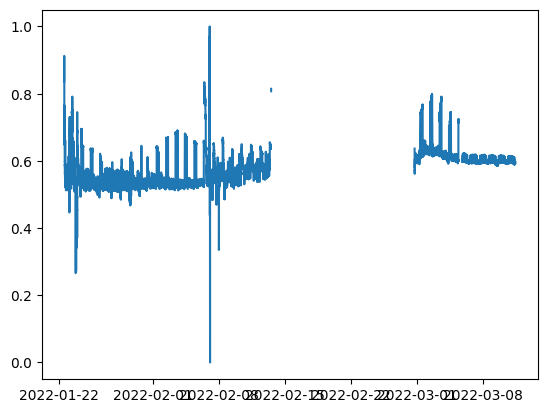

In [8]:
fig, ax = plt.subplots()
ax.plot(data_resampled.index.to_numpy(), data_resampled["differential_potential_CH1"].to_numpy())
plt.show()

apply sliding window to extract labeled data set

In [9]:
def time_indexed_data_to_sliding_window(df: pd.DataFrame, window_size=5):
    n_rows = df.shape[0]
    df = df.reset_index()
    windows = []
    for i in tqdm(range(n_rows-window_size)):
        window = df.loc[i:i+window_size-1,:]
        windows.append(np.array(window))


    return windows, ["batch", *df.columns]


data, column_names = time_indexed_data_to_sliding_window(data_resampled, window_size=5)
display(len(data), "window example:", pd.DataFrame(data[0], columns=column_names[1:]))

100%|██████████| 413134/413134 [01:17<00:00, 5351.52it/s]


413134

'window example:'

,timestamp,differential_potential_CH1,differential_potential_CH2,transpiration
0,2022-01-22 13:53:40,0.836353,0.536408,0.718769
1,2022-01-22 13:53:50,0.838699,0.519598,0.726964
2,2022-01-22 13:54:00,0.839003,0.520106,0.721901
3,2022-01-22 13:54:10,0.842335,0.518108,0.714783
4,2022-01-22 13:54:20,0.843746,0.517209,0.70977


convert windows to X, Y  data points and reject datapoints that contain nan

In [10]:
# returns format batch, len_x observations, label is next window_size-len_x observations
def convert_to_feature_labels(windows: list[np.ndarray], len_x = 4): # len_x < window_size, discards timestamp
    windows = [w[:,1:].astype(float) for w in windows] # reject timestamp (at col 0)
    valid_windows = [w for w in windows if not np.isnan(w).any()]
    features = [w[:len_x,:] for w in valid_windows]
    labels = [w[len_x:] for w in valid_windows]
    return np.array(features), np.array(labels)

features, labels = convert_to_feature_labels(data, len_x=4)   
display(features.shape, labels.shape)
features[0], labels[0]

(277925, 4, 3)

(277925, 1, 3)

(array([[0.83635333, 0.53640751, 0.71876864],
        [0.83869946, 0.51959845, 0.72696387],
        [0.83900298, 0.52010564, 0.72190089],
        [0.84233506, 0.51810784, 0.7147829 ]]),
 array([[0.84374593, 0.51720851, 0.70976964]]))

## Demo Simple Network
For experimentation with pytorch, define a simple network and train data on it

define encoder

In [13]:
# adapted from https://pytorch.org/tutorials/beginner/transformer_tutorial.html
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term) # TODO: why does this crash when d_model = 3?
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

class Encoder(nn.Module):
    def __init__(self, d_input, d_model):
        super(Encoder, self).__init__()
        # dummy parameter to store device
        self.device = device

        # define layers (layers are functions)
        self.input_layer = nn.Linear(d_input, d_model) # input layer, 10 features in, 10 features out (== keras dense)
        self.pos_encoding_layer = PositionalEncoding(d_model,dropout=0.2)
        self.encoder_layers = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=d_model, nhead=1, dropout=0.2), num_layers=4) # stacks multiple encoder layers, contains self attention and feed forward with normalization in between, TODO: how many heads?

    # forward pass data x through network
    def forward(self, x: torch.Tensor):
        x = self.input_layer(x)
        x = self.pos_encoding_layer(x)
        x = self.encoder_layers(x)
        return x

demo_data = torch.Tensor(features[0][:1,:]).to(device)
d_input = demo_data.shape[1] # columns as input dimension
d_model = 2
model = Encoder(d_input=d_input, d_model=d_model)
model.to(device)
display(demo_data)


model(demo_data)


tensor([[0.8364, 0.5364, 0.7188]])

tensor([[[ 1.0000, -1.0000]]], grad_fn=<NativeLayerNormBackward0>)

define decoder

In [18]:
        
class Decoder(nn.Module):
    def __init__(self, d_input, d_model):
        super(Decoder, self).__init__()
        # dummy parameter to store device
        self.device = device

        # define layers (layers are functions)
        self.input_layer = nn.Linear(d_input, d_model) # input layer, 10 features in, 10 features out (== keras dense)
        self.decoder_layers = nn.TransformerDecoder(nn.TransformerDecoderLayer(d_model=d_model, nhead=1, dropout=0.2), num_layers=4)
        self.linear_mapping = nn.Linear(
            in_features=d_model, 
            out_features=d_input
            )


    # forward pass data x through network
    def forward(self, x: torch.Tensor, memory: torch.Tensor): #NOTE: TODO: implement Masking
        x = self.input_layer(x)
        x = self.decoder_layers(x,memory=memory)
        x = self.linear_mapping(x)
        return x
    
demo_data_target = torch.Tensor(features[0][:1,:]).to(device)
demo_data_memory = torch.Tensor(features[0][2:3,:]).to(device)
d_input = demo_data_target.shape[1] # columns as input dimension
d_model = d_input # needs to be equal?
model = Decoder(d_input=d_input, d_model=d_model)
model.to(device)
display(demo_data)


model(demo_data_target, demo_data_memory)

tensor([[0.8364, 0.5364, 0.7188]])

tensor([[ 0.8869, -0.6424,  0.2984]], grad_fn=<AddmmBackward0>)

In [ ]:
d_input

3

Network Training

In [ ]:
#%%
net = SimpleNet()
net.to(device)
print(net)
#%%
for i in range (100):
    # main training loop / pipeline
    #data = torch.randn(10,10) # 10 data points (directly create batch of 10)
    # define mockup data
    data_x = [1,0,0,0,1,0,0,0,1,1]
    data_y = [0,1,1,1,0,1,1,1,0,0]
    input_layer = Variable(torch.Tensor([data_x for _ in range(10)])).to(net.device) # create as batch (duplicate for demonstration)
    target = Variable(torch.Tensor([data_y for _ in range(10)])).to(net.device) # s.o.
    
    # forward pass
    out = net(input_layer)
    loss = F.mse_loss(out, target)
    net.zero_grad() # net accumulates errors and needs to be reset manually each step

    # backpropagation
    loss.backward()
    learning_rate = 0.1
    optimizer = opt.SGD(net.parameters(), lr=learning_rate) # default stochastic gradient descent
    optimizer.step()
    
    print(loss)
#%%
# example result of trained net and conversion to numpy
x_numpy = np.array([1,0,0,0,1,0,0,0,1,1])
x = torch.Tensor(x_numpy).to(net.device)
y = net(x)
y_numpy = y.detach().cpu().numpy()
print("in  ", x_numpy.astype(np.int8))
print("out ", np.abs(np.rint(y_numpy)).astype(np.int8)) # as nearest (positive) int
# %%

NameError: name 'SimpleNet' is not defined